# Defining Nominal Approaches in fmdtools

Nominal simulation approaches are used to evaluate the performance of a model over a set of input parameters. It can then be used to:
- define/understand the operational envelope for different system parameters (i.e., what inputs can the system safely encounter)
- quantify failure probabilities given stochastic inputs (i.e., if the statistical distribution of inputs are known, what is the resulting probability of hazards given the design)

In [1]:
import sys, os
sys.path.insert(1,os.path.join(".."))

from fmdtools.modeldef import Model, FxnBlock
import fmdtools.resultdisp as rd
import fmdtools.faultsim.propagate as prop

The following rover model will be used to demonstrate this approach. The main task of the rover is to follow a given lane from a starting location to an ending location.

We can view the ability of the rover to track a given line with the following function:

In [2]:
import matplotlib.pyplot as plt
def plot_map(mdl, mdlhist):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x_ground = mdlhist['flows']['Ground']['x']
    y_ground = mdlhist['flows']['Ground']['liney']
    plt.plot(x_ground,y_ground, label="Centerline")
    
    x_rover = mdlhist['flows']['Ground']['x']
    y_rover = mdlhist['flows']['Ground']['y']
    plt.plot(x_rover,y_rover, label = "Rover")
    
    plt.scatter(mdl.params['end'][0],mdl.params['end'][1], label="End Location")
    plt.scatter(mdlhist['flows']['Ground']['x'][-1],mdlhist['flows']['Ground']['y'][-1], label="Final Position")
    
    plt.scatter(0,0, label="Start Location")

    plt.xlabel("x-distance (meters)")
    plt.ylabel("y-distance (meters)")
    plt.title("Rover Centerline Tracking")
    plt.grid()

    plt.legend()
    
    fig = plt.figure()
    if mdl.params['linetype']=='sine':
        y_line = [sin_func(x,y_rover[i], mdl.params['amp'], mdl.params['period'])[1] for i,x in enumerate(x_rover)]
    elif mdl.params['linetype']=='turn':
        y_line = [turn_func(x,y_rover[i], mdl.params['radius'], mdl.params['start'])[1] for i,x in enumerate(x_rover)]
        
    plt.plot(x_rover, y_rover-y_line)
    plt.xlabel("x-distance (meters)")
    plt.ylabel("y-error (meters)")
    plt.title("Rover Centerline Error")

Additionally, this model has a corresponding *parameter generation* function which generates the design parameters (`params`) of the model given a reduced space of input parameters. This is the set use-case because often the *explored* set of variables is smaller than the full set. Parameter generation functions are specified in the form `method(staticargs, rangearg1=x, rangearg2=y)`, where staticargs are arguments used to define discrete cases and rangeargs are arguments used to define corresponding varied parameters. 

In this case, the static cases are 'sine' or 'turn', the type of curve being generated in the function, with the corresponding range parameters of `amplitude` and `period` (of the wave used to generate the lane), and `radius` (of the turn) and `start` (distance before/after the curve starts/ends), respectively.

In [3]:
def gen_params(linetype, **kwargs):
    if linetype == 'sine':
        amp = kwargs.pop('amp',0.2)
        wavelength=kwargs.pop('wavelength', 50.0)
        period = 2*np.pi/wavelength
        initangle = sin_angle_func(0.0, amp, period)
        lineparams = {'linetype':linetype, 'amp':amp, 'period':period, 'initangle':initangle, 'end':[wavelength,0.0]}
    elif linetype == 'turn':
        radius = kwargs.pop('radius',20.0)
        start = kwargs.pop('start', 20.0)
        lineparams = {'linetype':linetype, 'radius':radius, 'start':start, 'initangle':0.0, 'end':[radius+start,radius+start]}
    return lineparams

Below is the rest of the model setup:

In [4]:
import numpy as np
class Avionics(FxnBlock):
    def __init__(self,name, flows, params):
        self.add_params(params)
        super().__init__(name, flows, flownames={'AvionicsControl':'Control'})
        self.assoc_modes({'no_con':[1e-4, 200]}, ['drive','standby'], initmode='standby')
    def dynamic_behavior(self,time):
        if not self.in_mode('no_con'):
            if time == 5: self.set_mode('drive')
            if time == 50 or in_area(self.end[0],self.end[1],1,self.Pos_Signal.x,self.Pos_Signal.y): 
                self.set_mode('standby')
                self.Control.completed=1
            
        if self.in_mode('drive'):
            self.Pos_Signal.assign(self.Video, 'angle', 'linex', 'liney')
            self.Pos_Signal.heading = self.Ground.ang 
            self.Pos_Signal.assign(self.Ground, 'x', 'y', 'vel')
            
            if in_area(self.end[0],self.end[1],1,self.Pos_Signal.x,self.Pos_Signal.y):
                self.set_mode('standby')
            elif self.Video.quality==0: self.set_mode('standby')
            else:
                ycorrection= np.arctan((self.Pos_Signal.y-self.Pos_Signal.liney)/(self.Pos_Signal.vel*np.cos(np.pi/180 * self.Pos_Signal.heading)+0.001))
                xcorrection= np.arctan((self.Pos_Signal.x-self.Pos_Signal.linex)/(self.Pos_Signal.vel*np.sin(np.pi/180 * self.Pos_Signal.heading)+0.001))
                rdiff = (self.Pos_Signal.angle - self.Pos_Signal.heading -5*(xcorrection+ycorrection))/180
                self.Control.put(rpower = 1+rdiff, lpower = 1-rdiff)
                self.Control.limit(rpower=(-1,2), lpower=(-1,2))  
        if self.in_mode('standby'):   self.Control.put(rpower = 0, lpower = 0)

class Drive(FxnBlock):
    def __init__(self,name, flows):
        super().__init__(name, flows, flownames={"EE_15":"EE_in"})
        self.assoc_modes({"mech_loss", "elec_open"})
    def dynamic_behavior(self, time):
        rpower = self.EE_in.v*self.MotorControl.rpower*self.no_fault("elec_open")/15
        lpower = self.EE_in.v*self.MotorControl.lpower*self.no_fault("elec_open")/15
        self.EE_in.a = (lpower + rpower)/12
        if (lpower + rpower) >100: self.add_fault("elec_open")
        else:
            self.Ground.vel= rpower + lpower
            self.Ground.inc(ang = 180*(rpower-lpower)/(rpower+lpower +0.001))
            self.Ground.inc(x = np.cos(np.pi/180 *self.Ground.ang) * self.Ground.vel, \
                            y = np.sin(np.pi/180 *self.Ground.ang) * self.Ground.vel)

class Perception(FxnBlock):
    def __init__(self, name, flows):
        self.set_atts(rad=1)
        super().__init__(name, flows, flownames={'EE_12':'EE'})
        self.assoc_modes({}, ['off', 'feed'], initmode='off')
    def dynamic_behavior(self,time):
        if self.in_mode('off'):
            self.EE.a=0
            self.Video.put(linex = 0,liney=0, angle = 0, quality = 0)
            if self.EE.v ==12: self.set_mode("feed")
        elif self.in_mode("feed"):
            if self.EE.v > 8:
                if in_area(self.Ground.x, self.Ground.liney, self.rad, self.Ground.x, self.Ground.y):
                    self.Video.assign(self.Ground, 'linex','liney', 'angle')
                    self.Video.quality = 1
                else:
                    self.Video.quality=0
            elif self.EE.v == 0: self.set_mode("off")
            else: self.Video.quality = 0

def in_area(x,y,rad,xc,yc):
    dist = np.sqrt((x-xc)**2+(y-yc)**2)
    return not dist > rad
    

class Power(FxnBlock):
    def __init__(self, name, flows):
        super().__init__(name,flows, states={"charge": 100.0, 'power':0.0})
        self.assoc_modes({"no_charge":[1e-5, {'off':1.0}, 100],"open_circ":[1e-5, {'supply':1.0}, 100]}, ["supply","charge","standby","off"], initmode="off", exclusive = True, key_phases_by='self')
    def static_behavior(self,time):
        if self.in_mode("off"):     
            self.EE_5.put(v=0,a=0); self.EE_12.put(v=0,a=0);self.EE_15.put(v=0,a=0)
            if self.Control.power==1 and self.AvionicsControl.completed==0:   self.set_mode("supply")
        elif self.in_mode("supply"):
            if self.charge > 0:         self.EE_5.v = 5; self.EE_12.v = 12; self.EE_15.v = 15; 
            else:                       self.set_mode("no_charge")
            if self.Control.power==0:   self.set_mode("off")
            elif self.AvionicsControl.completed==1: self.set_mode("off")
        elif self.in_mode("no_charge","open_circ"): self.EE_5.v = 0; self.EE_12.v = 0; self.EE_15.v = 0; 
        if self.in_mode("charge"):
            self.power = - 1
            if self.charge==100:self.set_mode("off")
        else:
            self.power=1+self.EE_12.mul('v','a')+self.EE_5.mul('v','a')+self.EE_15.mul('v','a')
    def dynamic_behavior(self,time):
        self.inc(charge = - self.power/100)
        self.limit(charge=(0,100))

class Override(FxnBlock):
    def __init__(self,name,flows):
        super().__init__(name,flows, flownames={'EE_5':'EE'})
        self.assoc_modes({}, ['off','standby','override'], initmode = 'off')
    def dynamic_behavior(self,time):
        if self.in_mode('off'):
            self.EE.a=0
            if self.EE.v==5: self.set_mode('standby')
        elif self.in_mode('standby'):
            self.MotorControl.assign(self.AvionicsControl, 'rpower','lpower')
            if self.OverrideComms =='active' and self.EE.v>4: self.set_mode('override')
        elif self.in_mode('override'):
            self.MotorControl.assign(self.OverrideComms, 'rpower', 'lpower')
   
class Communications(FxnBlock):
    def __init__(self, name, flows):
        super().__init__(name,flows)
    def dynamic_behavior(self,time):
        if self.EE_12.v == 12:
            self.EE_12.a=1
            self.Comms.assign(self.Pos_Signal, 'x', 'y', 'vel', 'heading')
        else:   self.Comms.put(x=0, y=0, vel=0, heading=0)

class Operator(FxnBlock):
    def __init__(self, name, flows):
        super().__init__(name,flows)
    def dynamic_behavior(self, t):
        if t==3:    self.Control.power=1
        elif t==55: self.Control.power=0

class Environment(FxnBlock):
    def __init__(self, name, flows,params):
        self.add_params(params)
        super().__init__(name,flows)
    def dynamic_behavior(self, t):
        if self.linetype=='sine':
            self.Ground.angle = sin_angle_func(self.Ground.x, self.amp, self.period)
            self.Ground.linex,self.Ground.liney = sin_func(self.Ground.x,self.Ground.y, self.amp, self.period)
        elif self.linetype=='turn':
            self.Ground.angle = turn_angle_func(self.Ground.x, self.radius, self.start)
            self.Ground.linex, self.Ground.liney = turn_func(self.Ground.x, self.Ground.y, self.radius, self.start)

def sin_func(x,y, amp, period):
    return x, amp * np.sin(period*x)
def sin_angle_func(x, amp, period):
    return amp * period * np.cos(period*x)*180/np.pi

def turn_func(x,y, radius,start):
    if   x >= start+radius: return start+radius, y
    elif y >= radius:       return start+radius, y
    elif x >= start:        return x, radius - np.sqrt(radius**2 - (x-start)**2)
    elif x < start:         return x, 0.0
def turn_angle_func(x, radius, start):
    if   x >= start+radius: return 90.0
    elif x >= start:        return 90.0 - np.arccos(((x-start)/radius))*180/np.pi  #np.arctan((x-start)/(radius**2-(start-x)**2))*180/np.pi
    elif x<start:           return 0.0

class Rover(Model):
    def __init__(self, params=gen_params('turn'),\
                 modelparams={'times':[0,60], 'tstep':1, 'phases':{'start':[1,30], 'end':[31, 60]}},\
                     valparams={}):
        super().__init__(params, modelparams, valparams)
        
        self.add_flow('Ground', {'x':0.0,'y':0.0,'liney':0.0,'linex':0.0, 'vel':0.0, 'line':0.0, 'angle':params['initangle'], 'ang':0.0})
        self.add_flow('Pos_Signal', {'x':0.0,'y':0.0,'liney':0.0,'linex':0.0, 'heading':0.0, 'vel':0.0, 'line':0, 'angle':0.0})
        self.add_flow('EE_12', {'v':0.0, 'a':0.0})
        self.add_flow('EE_5', {'v':0.0, 'a':0.0})
        self.add_flow('EE_15', {'v':0.0, 'a':0.0})
        self.add_flow('Video', {'liney':0.0,'linex':0.0, 'angle':params['initangle'], 'quality':1})
        self.add_flow('AvionicsControl', {'rpower':0.0, 'lpower':0.0, 'completed':0})
        self.add_flow('MotorControl', {'rpower':0.0, 'lpower':0.0})
        self.add_flow('Control', {'power':0.0})
        self.add_flow('Comms', {'x':0.0,'y':0.0, 'vel':0.0, 'heading':0.0})
        self.add_flow('OverrideComms', {'rpower':0.0, 'lpower':0.0, 'active':0} ) 
        #self.add_flow('Example_Disconnect')
        
        self.add_fxn("Power", ["EE_15","EE_5",'EE_12', "Control", "AvionicsControl"], Power)
        self.add_fxn("Operator", ["Comms", "OverrideComms", "Pos_Signal", "Control"], Operator)
        self.add_fxn("Communications", ["Comms", "EE_12", 'Pos_Signal'], Communications)
        self.add_fxn("Perception", ["Ground", "EE_12", "Video"], Perception)
        self.add_fxn("Avionics",["Video","Comms", "EE_5",'Pos_Signal',"Ground", "AvionicsControl"], fclass=Avionics, fparams=params)
        self.add_fxn("Override", ["OverrideComms", "EE_5", 'MotorControl','AvionicsControl'], Override)
        self.add_fxn("Drive", ["Ground","EE_15","EE_5", "MotorControl"], fclass = Drive)
        self.add_fxn("Environment", ['Ground'], Environment, fparams = params)
        
        pos_bip = {'Power': [-0.684772948203272, -0.2551613615446115],
                 'Operator': [-0.798933011500376, 0.565156755693186],
                 'Communications': [-0.5566050878414673, 0.14159180700630447],
                 'Perception': [0.996672509613648, 0.2507215448302319],
                 'Avionics': [0.28027473355741117, 0.47255264233968597],
                 'Override': [0.28987624783062627, -0.17144760874154652],
                 'Drive': [0.6671719569482308, -0.571646956655247],
                 'Environment': [1.1329643169383754, -0.6375225566564033],
                 'Ground': [1.108432946123935, -0.3228541151507237],
                 'Pos_Signal': [-0.256557435572734, 0.5411037985681082],
                 'EE_12': [-0.3676879520509888, -0.04754907961317867],
                 'EE_5': [-0.2181352416728437, -0.2015320865756482],
                 'EE_15': [-0.5352906801304353, -0.5288715575154177],
                 'Video': [0.6726175830840695, 0.396008366729458],
                 'AvionicsControl': [0.45997843863482324, 0.04522869632581994],
                 'MotorControl': [0.6350063940085445, -0.3013633829278297],
                 'Control': [-0.9857988678463686, 0.07960895587242012],
                 'Comms': [-0.642370284813957, 0.35285736707043763],
                 'OverrideComms': [-0.14607433032593392, 0.2981956996230818]}
        
        self.build_model(bipartite_pos = pos_bip)
    def find_classification(self,scen,mdlhist):
        modes, modeproperties = self.return_faultmodes()
        classification = str()
        if not in_area(self.flows['Ground'].x,self.flows['Ground'].y,1,self.params['end'][0],self.params['end'][1]):
                                classification = "incomplete mission"; cost=500
        if not classification:  classification = 'nominal mission'; cost=0
        if any(modes):          classification = classification +' faulty'; cost+=100
        return {'rate':0,'cost':cost, 'prob':scen['properties'].get('prob',1), 'expected cost':scen['properties'].get('prob',1)*cost, 'faults':modes, 'classification':classification}

Below shows the performance of the rover during a (default) turn with a radius of 20 meters that begins at 20 meters. As shown, there is a significant amount of drift, but not enough for the rover to get lost (that would take 1 meter of drift).

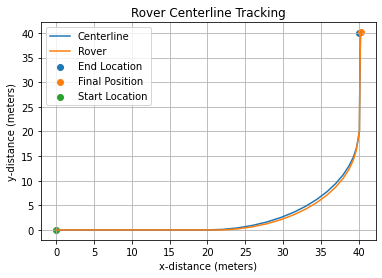

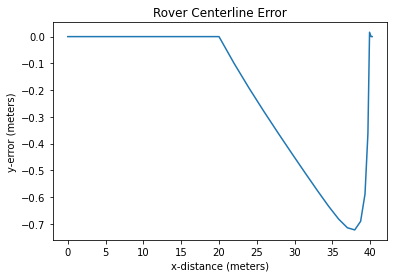

In [6]:
mdl = Rover(params=gen_params('turn'))
results, mdlhist = prop.nominal(mdl)
plot_map(mdl, mdlhist)

Below shows the performance of the model over a sine wave. As shown, the drift is much smaller because the turns are much less pronounced (a movement of 0.2 meters over 25 meters). 

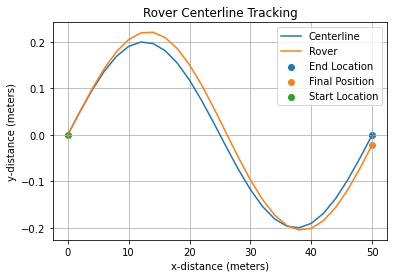

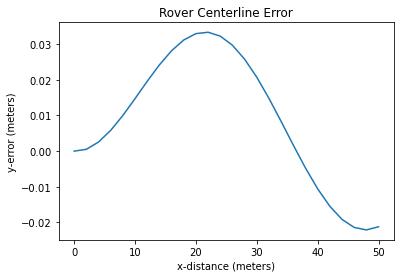

In [7]:
mdl = Rover(params=gen_params('sine'))
results, mdlhist = prop.nominal(mdl)
plot_map(mdl, mdlhist)

The performance of the rover in these situations is dependent on the parameters of the situation (e.g., the radius of the curve and the amplitude of the sine wave). Thus, it is important to define the operational envelope for the system. This can be done using a `NominalApproach`, which can be used to define ranges of variables to simulate the system under.

In [8]:
from fmdtools.modeldef import NominalApproach

In [9]:
help(NominalApproach)

Help on class NominalApproach in module fmdtools.modeldef:

class NominalApproach(builtins.object)
 |  Class for defining sets of nominal simulations. To explain, a given system 
 |  may have a number of input situations (missions, terrain, etc) which the 
 |  user may want to simulate to ensure the system operates as desired. This 
 |  class (in conjunction with propagate.nominal_approach()) can be used to 
 |  perform these simulations.
 |  
 |  Attributes
 |  ----------
 |  scenarios : dict
 |      scenarios to inject based on the approach
 |  num_scenarios : int
 |      number of scenarios in the approach
 |  ranges : dict
 |      dict of the parameters defined in each method for the approach
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Instantiates NominalApproach (simulation params are defined using methods)
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  add_param_ranges(self, paramfunc, rangeid, *args, replicates=1, seeds='shared', set_args={}, **k

In this approach we define parameter ranges for the two major situations--a wavelength and amplitude for the sine wave, and a radius and start location for the turn.

Defining an approach in terms of ranges is performed with `.add_param_ranges()`

In [10]:
nomapp = NominalApproach()
help(nomapp.add_param_ranges)

Help on method add_param_ranges in module fmdtools.modeldef:

add_param_ranges(paramfunc, rangeid, *args, replicates=1, seeds='shared', set_args={}, **kwargs) method of fmdtools.modeldef.NominalApproach instance
    Adds a set of scenarios to the approach.
    
    Parameters
    ----------
    paramfunc : method
        Python method which generates a set of model parameters given the input arguments.
        method should have form: method(fixedarg, fixedarg..., inputarg=X, inputarg=X)
    rangeid : str
        Name for the range being used. Default is 'nominal'
    *args: specifies values for positional args of paramfunc.
        May be given as a fixed float/int/dict/str defining a set value for positional arguments
    replicates : int
        Number of points to take over each range (for random parameters). Default is 1.
    seeds : str/list
        Options for seeding models/replicates: (Default is 'shared')
            - 'shared' creates random seeds and shares them between par

In [11]:
nomapp.add_param_ranges(gen_params,'sine','sine', amp=(0, 10, 0.2), wavelength=(10,50,10))
nomapp.add_param_ranges(gen_params,'turn','turn', radius=(5,40,5), start=(0, 20,5))

Notice that `gen_params` is the handle of the method defined earlier to generate the nominal parameters of the model, `sine` is a fixed parameter defining a discrete case of scenarios, and `amp` and `wavelenth` are parameters that are varied (the given tuples define the respective ranges).

The result is a defined set of scenarios which can be run in the model:

In [12]:
nomapp.scenarios

{'sine_1': {'sequence': {},
  'properties': {'type': 'nominal',
   'time': 0.0,
   'name': 'sine_1',
   'rangeid': 'sine',
   'params': {'linetype': 'sine',
    'amp': 0.0,
    'period': 0.6283185307179586,
    'initangle': 0.0,
    'end': [10, 0.0]},
   'inputparams': {'amp': 0.0, 'wavelength': 10},
   'modelparams': {'seed': 3861142359},
   'paramfunc': <function __main__.gen_params(linetype, **kwargs)>,
   'fixedargs': ('sine',),
   'fixedkwargs': {},
   'prob': 0.005}},
 'sine_2': {'sequence': {},
  'properties': {'type': 'nominal',
   'time': 0.0,
   'name': 'sine_2',
   'rangeid': 'sine',
   'params': {'linetype': 'sine',
    'amp': 0.0,
    'period': 0.3141592653589793,
    'initangle': 0.0,
    'end': [20, 0.0]},
   'inputparams': {'amp': 0.0, 'wavelength': 20},
   'modelparams': {'seed': 3861142359},
   'paramfunc': <function __main__.gen_params(linetype, **kwargs)>,
   'fixedargs': ('sine',),
   'fixedkwargs': {},
   'prob': 0.005}},
 'sine_3': {'sequence': {},
  'properties'

Nominal Approaches are simulated using `prop.nominal_approach`.

In [13]:
help(prop.nominal_approach)

Help on function nominal_approach in module fmdtools.faultsim.propagate:

nominal_approach(mdl, nomapp, **kwargs)
    Simulates a set of nominal scenarios through a model. Useful to understand
    the sets of parameters where the system will run nominally and/or lead to 
    a fault.
    
    Parameters
    ----------
    mdl : Model
        Model to simulate
    nomapp : NominalApproach
        Nominal Approach defining the nominal scenarios to run the system over.
    get_endclass : bool
        Whether to return endclasses from mdl.find_classification. Default is True.
    **kwargs : kwargs
        Additional keyword arguments, may include:
            - :data:`sim_kwargs` : kwargs
                Simulation options for :func:`prop_one_scen
            - :data:`run_kwargs` : kwargs
                Run options for :func:`nom_helper` and others
            - :data:`mult_kwargs` : kwargs
                Multi-scenario options for :func:`approach` and others
    Returns
    -------
    

In [14]:
endclasses, mdlhists= prop.nominal_approach(mdl, nomapp)

SCENARIOS COMPLETE: 100%|████████████████████████████████████████████████████████████| 228/228 [00:04<00:00, 49.17it/s]


To speed up execution over large numbers of scenarios, multiprocessing can also be used to run the scenarios in parallel by passing an execution pool. This is not done here because it would require the model to be in a different file, and because the gains on a light-weight model like this are not significant.

Now that the approach has been simulated, the operational envelope can be visualized. There are three methods to perform this visualization `rd.plot.nominal_vals_1d`, `rd.plot.nominal_vals_2d`, and `rd.plot.nominal_vals_3d`, which each plot the *classification* of the model in the 1/2/3 dimensions over the set of given parameters as nominal or incomplete. 

Note that this classification must be in the dictionary returned from the Model's `find_classification` function at the end of the model run under the key `classification` as is done in the rover model. This classification must also be encoded as a string.

In [15]:
help(rd.plot.nominal_vals_2d)

Help on function nominal_vals_2d in module fmdtools.resultdisp.plot:

nominal_vals_2d(nomapp, nomapp_endclasses, param1, param2, title='Nominal Operational Envelope', nomlabel='nominal', metric='classification', legendloc='best', figsize=(6, 4), xlabel='', ylabel='')
    Visualizes the nominal operational envelope along two given parameters
    
    Parameters
    ----------
    nomapp : NominalApproach
        Nominal sample approach simulated in the model.
    nomapp_endclasses : dict
        End-classifications for the set of simulations in the model.
    param1 : str
        First parameter (x) desired to visualize in the operational envelope
    param2 : str
        Second arameter (y) desired to visualize in the operational envelope
    title : str, optional
        Plot title. The default is "Nominal Operational Envelope".
    nomlabel : str, optional
        Flag for nominal end-states. The default is 'nominal'.
    xlabel: str, optional
        label for x-axis (defaults to pa

We can then use these results to visualize the operational envelope for the system over each case. In this case, the parameter ranges of the sine wave are plotted, showing that the rover can only a low ration of amplitude to wavelenght.

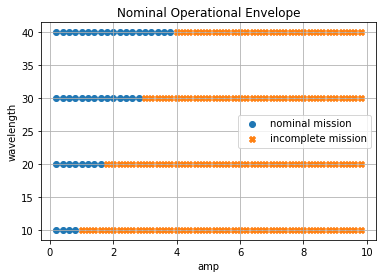

In [16]:
fig = rd.plot.nominal_vals_2d(nomapp, endclasses, 'amp', 'wavelength')

The plot below shows the same results for the turn parameters.

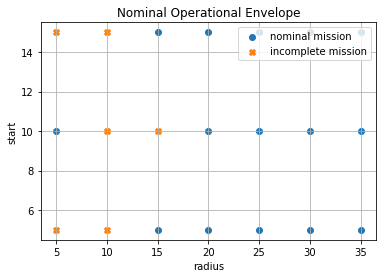

In [17]:
fig = rd.plot.nominal_vals_2d(nomapp, endclasses, 'radius', 'start')

Because the primary effect is one in terms of radius, we might visualize this trend in one dimension instead:

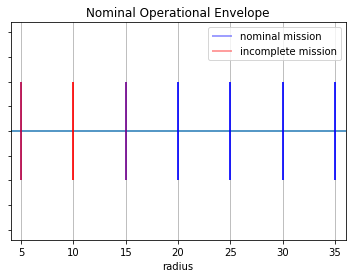

In [18]:
fig = rd.plot.nominal_vals_1d(nomapp, endclasses, 'radius')

While this is helpful for plotting string classifications, we also might want to compare numeric quantities (e.g., costs, hazard probabilities, etc) over the set of factors. For this, `rd.tabulate.nominal_factor_comparison` is used, which creates a table of  metrics over a given set of parameters.

In [19]:
help(rd.tabulate.nominal_factor_comparison)

Help on function nominal_factor_comparison in module fmdtools.resultdisp.tabulate:

nominal_factor_comparison(nomapp, endclasses, params, metrics='all', rangeid='default', nan_as=nan, percent=True, give_ci=False, **kwargs)
    Compares a metric for a given set of model parameters/factors over set of nominal scenarios.
    
    Parameters
    ----------
    nomapp : NominalApproach
        Nominal Approach used to generate the simulations
    endclasses : dict
        dict of endclasses from propagate.nominal_approach or nested_approach with structure: 
            {scen_x:{metric1:x, metric2:x...}} or {scen_x:{fault:{metric1:x, metric2:x...}}} 
    params : list/str
        List of parameters (or parameter) to use for the factor levels in the comparison
    metrics : 'all'/list, optional
        Metrics to show in the table. The default is 'all'.
    rangeid : str, optional
        Nominal Approach range to use for the test, if run over a single range.
        The default is 'default',

In [20]:
nomtab = rd.tabulate.nominal_factor_comparison(nomapp, endclasses, ['radius', 'start'], rangeid='turn', percent=False)

In [21]:
nomtab

5                                             10  \
                     0           5         10          15          0    
rate           0.000000    0.000000  0.000000    0.000000    0.000000   
cost           0.000000  500.000000  0.000000  500.000000  500.000000   
prob           0.035714    0.035714  0.035714    0.035714    0.035714   
expected cost  0.000000   17.857143  0.000000   17.857143   17.857143   

                                                         15            ...  \
                       5           10          15        0         5   ...   
rate             0.000000    0.000000    0.000000  0.000000  0.000000  ...   
cost           500.000000  500.000000  500.000000  0.000000  0.000000  ...   
prob             0.035714    0.035714    0.035714  0.035714  0.035714  ...   
expected cost   17.857143   17.857143   17.857143  0.000000  0.000000  ...   

                     25                  30                                \
                     10        15        0         5         10        15   
rate           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
cost           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
prob           0.035714  0.035714  0.035714  0.035714  0.035714  0.035714   
expected cost  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                     35                                
                     0         5         10        15  
rate           0.000000  0.000000  0.000000  0.000000  
cost           0.000000  0.000000  0.000000  0.000000  
prob           0.035714  0.035714  0.035714  0.035714  
expected cost  0.000000  0.000000  0.000000  0.000000  

[4 rows x 28 columns]

This table can also be summarized on individual factors:

In [22]:
nomtab_summ = rd.tabulate.nominal_factor_comparison(nomapp, endclasses, ['start'], rangeid='turn', percent=False)
nomtab_summ

"(start,)",0,5,10,15
rate,0.000000,0.000000,0.000000,0.000000
cost,71.428571,142.857143,142.857143,142.857143
prob,0.035714,0.035714,0.035714,0.035714
expected cost,2.551020,5.102041,5.102041,5.102041


`rd.plot.nominal_factor_comparison` can then be used to visualize one metric from this table as a bar plot.

In [23]:
help(rd.plot.nominal_factor_comparison)

Help on function nominal_factor_comparison in module fmdtools.resultdisp.plot:

nominal_factor_comparison(comparison_table, metric, ylabel='proportion', figsize=(6, 4), title='', maxy='max', xlabel=True, error_bars=False)
    Compares/plots a comparison table from tabulate.nominal_factor_comparison as a bar plot for a given metric.
    
    Parameters
    ----------
    comparison_table : pandas table
        Table from tabulate.nominal_factor_comparison
    metrics : string
        Metric to use in the plot
    ylabel : string, optional
        label for the y-axis. The default is 'proportion'.
    figsize : tuple, optional
        Size for the plot. The default is (12,8).
    title : str, optional
        Plot title. The default is ''.
    maxy : float
        Cutoff for the y-axis (to use if the default is bad). The default is 'max'
    xlabel : TYPE, optional
        DESCRIPTION. The default is True.
    error_bars : TYPE, optional
        DESCRIPTION. The default is False.
    
  

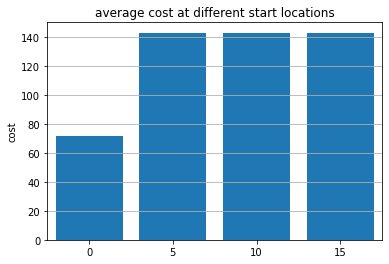

In [24]:
fig = rd.plot.nominal_factor_comparison(nomtab_summ, 'cost', ylabel='cost', title='average cost at different start locations', maxy=150)

## Quantifying probabilities

Given the ability to simulate over ranges, it can additionally be used to quantify probabilities of the different end-state classifications. `rd.process.state_probabilities(endclasses)` can be used to quantify the probability these classifications.

The default probability model over ranges is to assume a uniform distribution and only assume one range has been added. This can lead to fallacious results:

In [25]:
state_probabilities = rd.process.state_probabilities(endclasses)
state_probabilities

{'nominal mission': 0.9949999999999999,
 'incomplete mission': 1.0050000000000006}

Thus, `.assoc_probs` to:
- associate the probabilities with their corresponding distributions (which may be non-uniform), and
- rebalance the overall probability of discrete cases
when running the approach over ranges. 

In [26]:
help(nomapp.assoc_probs)

Help on method assoc_probs in module fmdtools.modeldef:

assoc_probs(rangeid, prob_weight=1.0, **inputpdfs) method of fmdtools.modeldef.NominalApproach instance
    Associates a probability model (assuming variable independence) with a 
    given previously-defined range of scenarios using given pdfs
    
    Parameters
    ----------
    rangeid : str
        Name of the range to apply the probability model to.
    prob_weight : float, optional
        Overall probability for the set of scenarios (to use if adding more ranges 
        or if the range does not cover the space of probability). The default is 1.0.
    **inputpdfs : key=(pdf, params)
        pdf to associate with the different variables of the model. 
        Where the pdf has form pdf(x, **kwargs) where x is the location and **kwargs is parameters
        (for example, scipy.stats.norm.pdf)
        and params is a dictionary of parameters (e.g., {'mu':1,'std':1}) to use '
        as the key/parameter inputs to the pdf



Here, each case is given a weight defining the probability of the discrete case, while the corresponding parameters are given corresponding pdf functions (in this case uniform distributions from the scipy stats package).

In [27]:
from scipy import stats

In [28]:
nomapp.assoc_probs('sine', prob_weight=0.5, amp=(stats.uniform.pdf, {'loc':0,'scale':10}), wavelength=(stats.uniform.pdf,{'loc':10, 'scale':40}))
nomapp.assoc_probs('turn', prob_weight=0.5, start=(stats.uniform.pdf, {'loc':5,'scale':10}), radius=(stats.uniform.pdf,{'loc':5, 'scale':30}))

Now, when the scenarios are run, they should have the correct corresponding probabilities:

In [29]:
endclasses, mdlhists= prop.nominal_approach(mdl, nomapp)

SCENARIOS COMPLETE: 100%|████████████████████████████████████████████████████████████| 228/228 [00:04<00:00, 53.22it/s]


In [30]:
state_probabilities = rd.process.state_probabilities(endclasses)
state_probabilities

{'nominal mission': 0.4796428571428575,
 'incomplete mission': 0.5203571428571433}

This result (while seemingly extreme due to the large ranges explored) is consistent with the operational envelopes presented earlier.

## Random input generation

It may additionally be helpful to perform simulations over randomly generated inputs, when there are many parameters and it is difficult to easily quantify the stochastic process. This approach is called Monte Carlo sampling, and enables one to quantify probabilities given stochasticly-generated inputs. Random inputs are assigned using `.add_rand_params`

In [31]:
nomapp_rand = NominalApproach()
help(nomapp_rand.add_rand_params)

Help on method add_rand_params in module fmdtools.modeldef:

add_rand_params(paramfunc, rangeid, *fixedargs, prob_weight=1.0, replicates=1000, seeds='shared', **randvars) method of fmdtools.modeldef.NominalApproach instance
    Adds a set of random scenarios to the approach.
    
    Parameters
    ----------
    paramfunc : method
        Python method which generates a set of model parameters given the input arguments.
        method should have form: method(fixedarg, fixedarg..., inputarg=X, inputarg=X)
    rangeid : str
        Name for the range being used. Default is 'nominal'
    prob_weight : float (0-1)
        Overall probability for the set of scenarios (to use if adding more ranges). Default is 1.0
    *fixedargs : any
        Fixed positional arguments in the parameter generator function. 
        Useful for discrete modes with different parameters.
    seeds : str/list
        Options for seeding models/replicates: (Default is 'shared')
            - 'shared' creates rand

Below, the same probability model/scenarios used above will be generated using stochastic inputs (rather than a range).

In [32]:
import numpy as np

In [33]:
nomapp_rand.add_rand_params(gen_params,'sine','sine', prob_weight=0.5, replicates=100, amp=(np.random.uniform, 0, 10), wavelength=(np.random.uniform,10,40))
nomapp_rand.add_rand_params(gen_params,'turn','turn', prob_weight=0.5, replicates=100, radius=(np.random.uniform,5,40), start=(np.random.uniform,0, 20))

We can go through the same process to verify that it tracks the range/pdf method.

In [34]:
endclasses, mdlhists= prop.nominal_approach(mdl, nomapp_rand)

SCENARIOS COMPLETE: 100%|████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 53.40it/s]


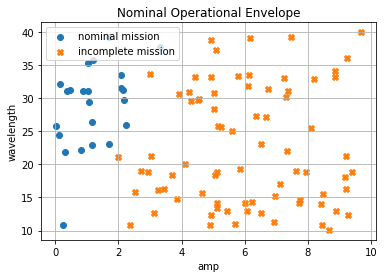

In [35]:
fig = rd.plot.nominal_vals_2d(nomapp_rand, endclasses, 'amp', 'wavelength')

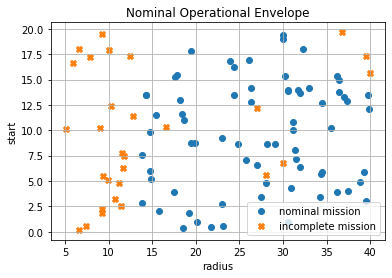

In [36]:
fig = rd.plot.nominal_vals_2d(nomapp_rand, endclasses, 'radius', 'start')

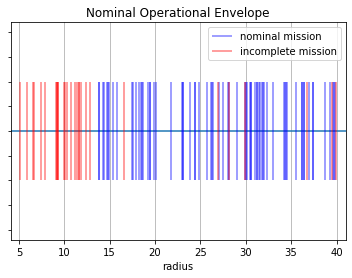

In [37]:
fig = rd.plot.nominal_vals_1d(nomapp_rand, endclasses, 'radius')

As shown, these results track the uniform approach, although the spread catches some non-nominal scenarios that were not caught using uniform sampling. The resulting probabilities are:

In [38]:
state_probabilities = rd.process.state_probabilities(endclasses)
state_probabilities

{'nominal mission': 0.4700000000000003,
 'incomplete mission': 0.5300000000000004}

Which is similar to (but not exactly the same as) the uniform approach. The error of Monte Carlo sampling approaches can be reduced by increasing the number of points, but these points increase computational costs.

## Nested Scenario Sampling

Thus far, we have introduced two types of approaches: 
- SampleApproach, which is used to evaluate the system resilience to a set of faults
- NominalApproach, which is used to evaluate system performance over a set of parameters

These both have their limitations when used alone. Simulating a `SampleApproach` using `propagate.approach` solely evaluates evaluates fault-driven hazards in a single nominal set of parameters (which may not generalize) while simulating a `NominalApproach` using `propagate.nominal_approach` evaluates the systerm performance/resilience to external parameters (But not faults).

To resolve these limitations, one can use a *nested* scenario sampling approach where a `SampleApproach` is simulated at each parameter level of a `NominalApproach`, giving the resilience of the system to faults over a set of operational parameters. This is called using the `propagate.nested_approach` method.

In [39]:
help(prop.nested_approach)

Help on function nested_approach in module fmdtools.faultsim.propagate:

nested_approach(mdl, nomapp, get_phases=False, **kwargs)
    Simulates a set of fault modes within a set of nominal scenarios defined by a nominal approach.
    
    Parameters
    ----------
    mdl : Model
        Model Object to use in the simulation.
    nomapp : NominalApproach
        NominalApproach defining the nominal situations the model will be run over
    get_phases : Bool/List/Dict, optional
        Whether and how to use nominal simulation phases to set up the SampleApproach. The default is False.
        - If True, all phases from the nominal simulation are passed to SampleApproach()
        - If a list ['Fxn1', 'Fxn2' etc.], only the phases from the listed functions will be passed.
        - If a dict {'Fxn1':'phase1'}, only the phase 'phase1' in the function 'Fxn1' will be passed.
    **kwargs : kwargs
        Additional keyword arguments, may include:
            - :data:`sim_kwargs` : kwargs
  

Here we use the nominal approach generated earlier with a default sampling approach to quantify resilience.

In [40]:
nested_endclasses, nested_mdlhists, nested_apps = prop.nested_approach(mdl, nomapp)

NESTED SCENARIOS COMPLETE: 100%|█████████████████████████████████████████████████████| 228/228 [00:36<00:00,  6.21it/s]


 The resulting endclass/mdlhist dictionary is in turn nested within operational scenarios.

In [41]:
nested_endclasses.keys()

dict_keys(['sine_1', 'sine_2', 'sine_3', 'sine_4', 'sine_5', 'sine_6', 'sine_7', 'sine_8', 'sine_9', 'sine_10', 'sine_11', 'sine_12', 'sine_13', 'sine_14', 'sine_15', 'sine_16', 'sine_17', 'sine_18', 'sine_19', 'sine_20', 'sine_21', 'sine_22', 'sine_23', 'sine_24', 'sine_25', 'sine_26', 'sine_27', 'sine_28', 'sine_29', 'sine_30', 'sine_31', 'sine_32', 'sine_33', 'sine_34', 'sine_35', 'sine_36', 'sine_37', 'sine_38', 'sine_39', 'sine_40', 'sine_41', 'sine_42', 'sine_43', 'sine_44', 'sine_45', 'sine_46', 'sine_47', 'sine_48', 'sine_49', 'sine_50', 'sine_51', 'sine_52', 'sine_53', 'sine_54', 'sine_55', 'sine_56', 'sine_57', 'sine_58', 'sine_59', 'sine_60', 'sine_61', 'sine_62', 'sine_63', 'sine_64', 'sine_65', 'sine_66', 'sine_67', 'sine_68', 'sine_69', 'sine_70', 'sine_71', 'sine_72', 'sine_73', 'sine_74', 'sine_75', 'sine_76', 'sine_77', 'sine_78', 'sine_79', 'sine_80', 'sine_81', 'sine_82', 'sine_83', 'sine_84', 'sine_85', 'sine_86', 'sine_87', 'sine_88', 'sine_89', 'sine_90', 'sine_91

In [42]:
nested_endclasses['sine_1']['nominal']

{'rate': 0,
 'cost': 0,
 'prob': 1,
 'expected cost': 0,
 'faults': {},
 'classification': 'nominal mission'}

We can compare resilience to faults over the operational envelope using `rd.tabulate.resilience_factor_comparison`, which generates at table similar to `rd.tabulate.nominal_factor_comparison` except for a single metric with rows for each fault scenario.

In [43]:
restab = rd.tabulate.resilience_factor_comparison(nomapp, nested_endclasses,['start'], 'cost', rangeid='turn', percent=False, difference=False)

In [44]:
restab

"(start,)",nominal,Drive,Avionics
0,71.428571,260.714286,171.428571
5,142.857143,332.142857,242.857143
10,142.857143,332.142857,242.857143
15,142.857143,350.000000,242.857143


These factors can further be visualized using `rd.plot.resilience_factor_comparison`, which generates a set of bar graphs similar to `rd.plot.nominal_factor_comparison`.

In [45]:
help(rd.plot.resilience_factor_comparison)

Help on function resilience_factor_comparison in module fmdtools.resultdisp.plot:

resilience_factor_comparison(comparison_table, faults='all', rows=1, stat='proportion', figsize=(12, 8), title='', maxy='max', legend='single', stack=False, xlabel=True, error_bars=False)
    Plots a comparison_table from tabulate.resilience_factor_comparison as a bar plot for each fault scenario/set of fault scenarios.
    
    Parameters
    ----------
    comparison_table : pandas table
        Table from tabulate.resilience_factor_test with factors as rows and fault scenarios as columns
    faults : list, optional
        iterable of faults/fault types to include in the bar plot (the columns of the table). The default is 'all'.
        a dictionary {'fault':'title'} will associate the given fault with a title (otherwise 'fault' is used)
    rows : int, optional
        Number of rows in the multplot. The default is 1.
    stat : str, optional
        Metric being presented in the table (for the y-axi

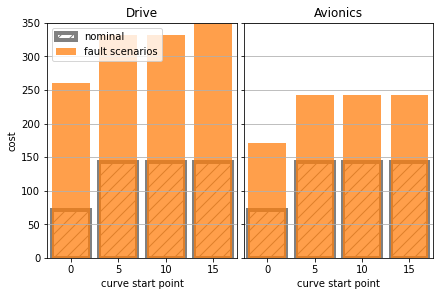

In [46]:
fig = rd.plot.resilience_factor_comparison(restab, stat='cost', figsize = (6,4), xlabel='curve start point')

As shown, on average the costs are higher over fault scenarios than in their nominal counterparts. While this difference appears to be uniform for Avionics faults (`no_con`, which merely adds a fault at the times instantiated (since the rover is already in `drive` mode)), resulting in a uniform cost of 100), it changes for the Drive fault depending on the location of the curve. This is because in some cases this fault stops the rover at the finish line (when the line is short), and sometimes during its mission (when the line is long), leading to a cost from the incomplete mission.

Thus, the assessed consequences of faults are somewhat prone to parameters leading to a different injection time. We might prefer, for example, for avionics faults to be injected when they would make a difference (i.e. at the start) and for drive faults to be injected multiple. This can be fixed by:
- encoding phase information in with modes to ensure they are injected at the right intervals
- using the `get_phases` option in `propagate.nested_approach` to get the phases and inject the faults in the corresponding times
- passing appropriate Approach arguments to `propagate.nested_approach` (e.g., defaultsamp, etc)

This has already been done in the Power faults, which we evaluate below. (note that they were not included above because they were listed to be injected in specific phases using the `key_phases_by` option in `assoc_modes()`).

In [47]:
nested_endclasses_power, nested_mdlhists_power, nested_apps_power = prop.nested_approach(mdl, nomapp, get_phases=True, faults='Power')

NESTED SCENARIOS COMPLETE: 100%|█████████████████████████████████████████████████████| 228/228 [00:20<00:00, 11.34it/s]


In [48]:
restab_power = rd.tabulate.resilience_factor_comparison(nomapp, nested_endclasses_power,['start'], 'cost', rangeid='turn', difference=True, percent=False, faults='modes')
restab_power

"(start,)",nominal,Power open_circ,Power no_charge
0,71.428571,528.571429,528.571429
5,142.857143,457.142857,457.142857
10,142.857143,457.142857,457.142857
15,142.857143,457.142857,457.142857


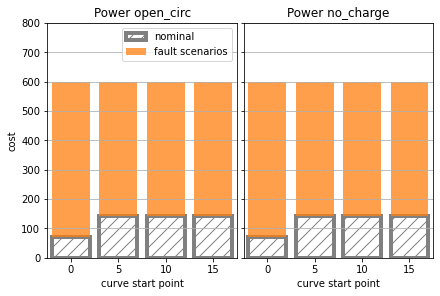

In [49]:
fig = rd.plot.resilience_factor_comparison(restab_power, stat='cost', figsize = (6,4), xlabel='curve start point', stack=True, maxy=800)

As shown, all power faults result in the same cost, since they all result in both a fault and an incomplete mission, in part because none of them are injected after the rover completes its mission (which would happen if we were using the global phases as in the drive faults).